In [49]:
import os
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [50]:
#load data and labels
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
label_map_path  = os.path.join(data_dir,'label_num_to_phase_map.json')
train_csv = os.path.join(data_dir, 'train.csv')
test_csv = os.path.join(data_dir, 'test.csv')
IMG_SIZE = (224, 224)

In [51]:
#load csv
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [52]:
# helper to load and preprocess images
def load_images_and_labels(df, folder):
    images = []
    labels = []
    for i, row in df.iterrows():
        img_path = os.path.join(folder, row['image_id'])
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

In [53]:
#load train/test sets
X_train, y_train = load_images_and_labels(train_df, train_dir)
X_test, y_test = load_images_and_labels(test_df, test_dir)

In [86]:
# build model with fine-tuning
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

inputs = Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
model = Model(inputs, x)
len(base_model.layers)

175

In [83]:
#extract features
X_train_feats = model.predict(X_train, batch_size=32)
X_test_feats = model.predict(X_test, batch_size=32)

5/5 [==============================] - 0s 80ms/step


In [84]:
#train classifiers
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_feats, y_train)
log_preds = log_reg.predict(X_test_feats)
log_acc = accuracy_score(y_test, log_preds)

svm = SVC()
svm.fit(X_train_feats, y_train)
svm_preds = svm.predict(X_test_feats)
svm_acc = accuracy_score(y_test, svm_preds)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_feats, y_train)
knn_preds = knn.predict(X_test_feats)
knn_acc = accuracy_score(y_test, knn_preds)

In [85]:
#print results
print("Logistic Regression Accuracy:", log_acc)
print("SVM Accuracy:", svm_acc)
print("KNN Accuracy:", knn_acc)

Logistic Regression Accuracy: 0.7785714285714286
SVM Accuracy: 0.6357142857142857
KNN Accuracy: 0.6285714285714286


<Figure size 1000x800 with 0 Axes>

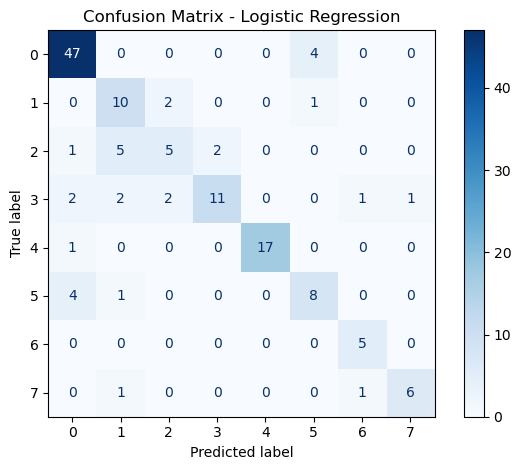

In [58]:
#logistic regression confusion matrix
cm = confusion_matrix(y_test, log_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

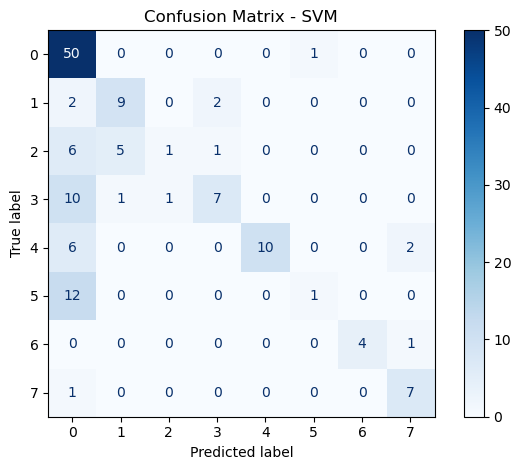

In [59]:
#svm confusion matrix
cm = confusion_matrix(y_test, svm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

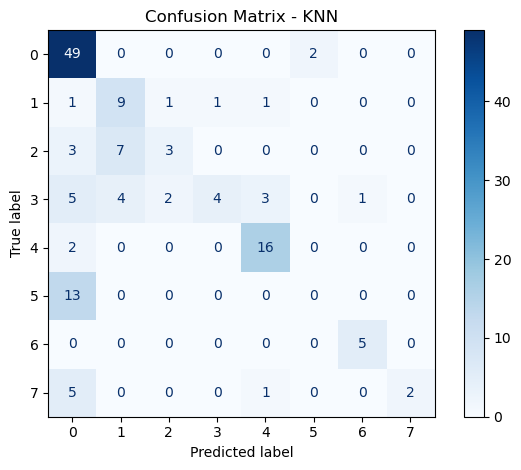

In [60]:
#knn confusion matrix
cm = confusion_matrix(y_test, knn_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.tight_layout()
plt.show()